# Recommendation system

## Imports

Для начала импортируем библиотеки, которые понадобятся нам для исследовательского анализа данных и дальнейшего построения рекомендательной системы:

In [1]:
import os
import joblib
from datetime import datetime

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from implicit.cpu.als import AlternatingLeastSquares
from pandas.errors import MergeError
from sklearn.preprocessing import LabelEncoder

RAW_DATA_DIR = "../data"
RECOMMENDATIONS_DATA_DIR = "../fastapi_service/recommendations"
POSTGRES_DATA_DIR = "../airflow_service/postgres_data"
ASSETS_DIR = "./assets"
RANDOM_STATE = 2049
EXPERIMENT_NAME = "RECSYS_DEV_EXPERIMENT"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

sns.set_theme()

Теперь создадим несколько директорий (если они еще не созданы) для хранения следующих типов файлов:

* `ASSETS_DIR` => Артефакты для логирования в Mlflow;
* `RECOMMENDATIONS_DATA_DIR` => Таблицы с рекомендациями, которые будут использоваться для генерации рекомендаций во время работы сервиса `fastapi_service`. Сюда из базы данных будут попадать уже готовые таблицы с рекомендациями для показа пользователям при взаимодействии с сервисом;
* `POSTGRES_DATA_DIR` => Таблицы с рекомендациями, а также кандидаты для тренировки и инференса модели, которые используются в графах Airflow в `airflow_service`. Из данной папки все файлы, созданные в этом ноутбуке будут отправляться в базу данных посредством Airflow;

Таким образом, созданные файлы будем сразу сохранять именно в ту директорию, в которой они будут в дальнейшем использоваться.

In [2]:
# Directory for mlflow artifacts to be logged
if not os.path.exists(ASSETS_DIR):
    os.mkdir(ASSETS_DIR)

# Directory for recommendations to be used in a FastAPI service
if not os.path.exists(RECOMMENDATIONS_DATA_DIR):
    os.mkdir(RECOMMENDATIONS_DATA_DIR)

# Directory for data to be used in Airflow DAGs
if not os.path.exists(POSTGRES_DATA_DIR):
    os.mkdir(POSTGRES_DATA_DIR)

## Mlflow tracking

Теперь запускаем трэкинг Mlflow, чтобы можно было производить логирование артефактов, которые будем получать на различных этапах. 

*NOTE*: Перед запуском следующих двух ячеек сналача необходимо развернуть Mlflow с хранилищем артефактов следующими командами из корневой директории проекта:

```bash
cd recsys
sh run_mlflow_server.sh
```

После запуска скрипта сервер Mlflow будет развернут на порте 5000. Запускаем трэкинг:

In [3]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

В следующей ячейке мы создадим эксперимент (если он еще не создан), в который будем впоследствии логировать артефакты:

In [4]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

In [5]:
print("Experiment name: {}".format(EXPERIMENT_NAME))
print("Experiment number: {}".format(experiment_id))

Experiment name: RECSYS_DEV_EXPERIMENT
Experiment number: 19


## Loading data

Теперь загрузим данные:

In [6]:
%%time
category_tree = pd.read_csv(f"{RAW_DATA_DIR}/category_tree.csv")
events = pd.read_csv(f"{RAW_DATA_DIR}/events.csv")
item_props_1 = pd.read_csv(f"{RAW_DATA_DIR}/item_properties_part1.csv")
item_props_2 = pd.read_csv(f"{RAW_DATA_DIR}/item_properties_part2.csv")

CPU times: user 10.1 s, sys: 1.29 s, total: 11.4 s
Wall time: 21.8 s


## Exploratory data analysis

Прежде чем переходить непосредственно к созданию системы рекомендаций товаров, необходимо сначала изучить данные, выявить их особенности и некоторые закономерности. 

Рассмотрим каждый датафрейм, созданный на предыдущем этапе, по-отдельности:

* Category tree => `category_tree`
* Events => `events`
* Item properties => `item_props_1`, `item_props_2`

### Category tree

In [ ]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


Данная таблица представляет собой 2 столбца, где мы имеем определенные категории и родительские категогии, к которым они относятся. Посмотрим, как это выглядит:

In [8]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


На первый вгляд неясно, что к чему относится, но если взять например родительскую категорию 1698:

In [9]:
category_tree.query("parentid == 1698")

,categoryid,parentid
1276,1160,1698.0
1283,110,1698.0
1299,1678,1698.0
1300,1034,1698.0
1328,1582,1698.0
1406,1502,1698.0
1651,760,1698.0


Видим, что к некой большой категории с номером 1698 относятся некоторые категории, к которым в свою очередь относятся товары, которые нам предстоит рекомендовать пользователям.

Проверим уникальные значения в каждой из колонок:

In [10]:
cat_ids_unique = category_tree.categoryid.nunique()
par_ids_unique = category_tree.parentid.nunique()

print("Number of unique categories: {:,}".format(cat_ids_unique))
print("Number of unique parent categories: {:,}".format(par_ids_unique))

Number of unique categories: 1,669
Number of unique parent categories: 362


Итак, в данных есть 362 комплексных групп, к которым относятся некоторые из 1669 категорий, содержащих разные товары.

Посмотрим на пропуски:

In [11]:
category_tree.isnull().sum()

categoryid     0
parentid      25
dtype: int64

Получается, что некоторые категории не имеют более старших групп, то есть возможно, что такие категории и являются группами. Для наглядности выведем такие категории:

In [12]:
category_tree[category_tree.parentid.isnull() == True]

,categoryid,parentid
5,231,NaN
589,791,NaN
861,1490,NaN
939,431,NaN
1111,755,NaN
1142,378,NaN
1208,1579,NaN
1211,1394,NaN
1322,659,NaN
1329,1057,NaN


Можем также посмотреть на самые многочисленные группы (возьмем топ-30):

In [16]:
category_tree \
            .groupby("parentid") \
            .agg({"categoryid": "count"}) \
            .sort_values(by="categoryid", ascending=False) \
            .reset_index() \
            .head(30)

,parentid,categoryid
0,250.0,31
1,1009.0,22
2,362.0,22
3,351.0,19
4,1259.0,18
5,1687.0,17
6,945.0,15
7,312.0,15
8,893.0,13
9,1482.0,13


### Events

Теперь посмотрим на события: действия, которые пользователи делали с товарами:

In [17]:
events.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 244.9 MB


In [18]:
events.sample(10, random_state=RANDOM_STATE)

,timestamp,visitorid,event,itemid,transactionid
487392,1435134103816,1286569,view,358594,NaN
2356113,1436929418282,880315,view,373842,NaN
812145,1439414093765,78620,view,211458,NaN
1567508,1431030652925,368177,view,434214,NaN
763670,1439181882071,491079,view,364147,NaN
49005,1433391715926,776534,view,20388,NaN
2185894,1436321400086,1200367,view,367588,NaN
1069940,1440630508956,393638,view,125466,NaN
759499,1439101521391,223358,view,411200,NaN
1245597,1441475607939,229502,transaction,12720,5654.0


Итак, у нас есть порядка двух миллионов различных действий пользователей с товарами, где каждый такой пользователь отмечен в колонке `visitorid`, который выполнял с товаром в `itemid` действие в колонке `event`. Дополнительно у нас есть временная метка `timestamp` с идентификаторов покупки в `transactionid`.

Например, посмотрим на данные для различных пользователей:

In [19]:
events.query("visitorid == 355903")

,timestamp,visitorid,event,itemid,transactionid
1140018,1440996791626,355903,view,389780,NaN
1145219,1440996740746,355903,view,102903,NaN
1145255,1440996903983,355903,view,269631,NaN
1145262,1440996962079,355903,view,136524,NaN


In [20]:
events.query("visitorid == 599729")

,timestamp,visitorid,event,itemid,transactionid
741075,1439005882692,599729,view,442793,NaN


In [21]:
events.query("visitorid == 50734")

,timestamp,visitorid,event,itemid,transactionid
473003,1435192011355,50734,view,101718,NaN
475456,1435191902774,50734,view,365204,NaN
485288,1435191946820,50734,view,365204,NaN
486752,1435191236400,50734,view,272907,NaN
486798,1435193216976,50734,view,4442,NaN
486857,1435192854825,50734,view,4442,NaN
490545,1435194074910,50734,view,365204,NaN
539163,1435352138722,50734,view,79285,NaN


Взятые три случайных пользователя по нашим данным просто просматривали товары без каких-то дальнейших действий. 

Посмотрим на данные, где все же был зафиксирован факт покупки:

In [22]:
events[~events.transactionid.isna()]

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0
814,1433176736375,102019,transaction,150318,13556.0
843,1433174518180,189384,transaction,310791,7244.0
...,...,...,...,...,...
2755294,1438377176570,1050575,transaction,31640,8354.0
2755349,1438379878779,861299,transaction,456602,3643.0
2755508,1438357730123,855941,transaction,235771,4385.0
2755603,1438355560300,548772,transaction,29167,13872.0


Только около 22 тысячи действий пользователей из двух миллионов привели к покупке (около 0.8%), что отмечено действием `transaction`.

Возьмем трех таких пользователей:

In [23]:
events.query("visitorid == 599528")

,timestamp,visitorid,event,itemid,transactionid
112,1433221941632,599528,addtocart,356475,NaN
130,1433222276276,599528,transaction,356475,4000.0
16729,1433221896102,599528,view,356475,NaN
29505,1433297545235,599528,view,356475,NaN
114163,1433625010602,599528,view,356475,NaN
145498,1433731497480,599528,view,356475,NaN
171995,1433896477794,599528,view,356475,NaN
187497,1433896449376,599528,view,356475,NaN
192471,1433960567121,599528,view,356475,NaN
197272,1433960259198,599528,view,356475,NaN


In [24]:
events.query("visitorid == 1051054")

,timestamp,visitorid,event,itemid,transactionid
2739787,1438359416397,1051054,transaction,463002,11404.0
2739839,1438358858548,1051054,addtocart,312728,NaN
2755578,1438359194127,1051054,addtocart,463002,NaN
2755593,1438358847786,1051054,view,312728,NaN
2755607,1438358989163,1051054,transaction,312728,17579.0


In [25]:
events.query("visitorid == 861299").tail(15)

,timestamp,visitorid,event,itemid,transactionid
2754118,1438365085777,861299,view,204057,NaN
2754591,1438383952746,861299,view,391484,NaN
2754701,1438370210252,861299,view,546,NaN
2754754,1438368794533,861299,view,367032,NaN
2754872,1438370067882,861299,view,546,NaN
2754908,1438390902050,861299,view,295448,NaN
2754994,1438388002882,861299,view,243355,NaN
2755003,1438386491922,861299,view,30308,NaN
2755033,1438389817314,861299,addtocart,191763,NaN
2755156,1438376953339,861299,transaction,22969,14059.0


Видим, что до покупки пользователь добавляет товар в корзину (действие `addtocart`). Из действий случайных трех пользователей видно, что так обычно и происходит, но есть действия, где после добавления товара в корзину ничего не случается дальше, то есть добавление в корзинуне всегда конвертируется в покупку.

Расчитаем число уникальных пользователей и товаров:

In [26]:
users_unique = events.visitorid.nunique()
items_unique = events.itemid.nunique()

print("Number of unique users: {:,}".format(users_unique))
print("Number of unique items: {:,}".format(items_unique))

Number of unique users: 1,407,580
Number of unique items: 235,061


Наблюдаем довольно обширное число товаров вместе с почти полутора миллиона пользователей.

Посмотрим, как распределены действия пользователей:

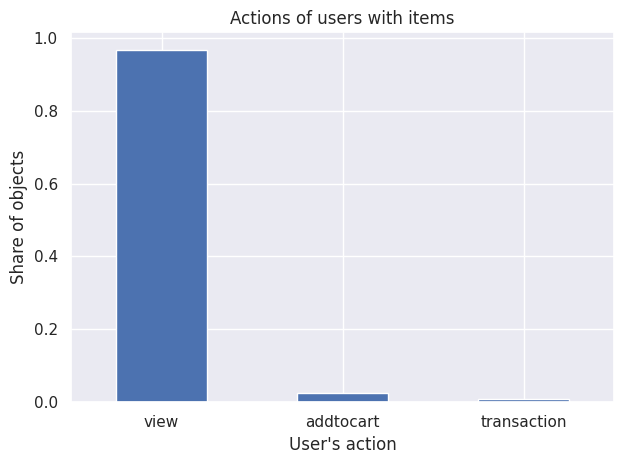

In [27]:
events.event \
    .value_counts(normalize=True) \
    .plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Share of objects")
plt.xlabel("User's action")
plt.title("Actions of users with items")
plt.tight_layout()
plt.savefig(f"{ASSETS_DIR}/user_actions.png")
plt.show()

Видно, что в основном пользователи только смотрят товары, но не все такие действия реализуются в покупку (об этом свидетельствует чуть более высокая величина столбика для `addtocart` по сравнению с `transaction`). Даже добавление в корзину (как было замечено выше) не всегда приводит к покупке. Например, пользователь может добавить товар в корзину, чтобы сохранить его на будущее.

Посмотрим на транзакции подробнее:

In [28]:
events_transactions = events[~events.transactionid.isna()]
events_transactions

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0
814,1433176736375,102019,transaction,150318,13556.0
843,1433174518180,189384,transaction,310791,7244.0
...,...,...,...,...,...
2755294,1438377176570,1050575,transaction,31640,8354.0
2755349,1438379878779,861299,transaction,456602,3643.0
2755508,1438357730123,855941,transaction,235771,4385.0
2755603,1438355560300,548772,transaction,29167,13872.0


In [29]:
events.transactionid.nunique()

17672

In [30]:
events_transactions[
    events_transactions.duplicated(subset=["transactionid"])
].sort_values(by="transactionid")

,timestamp,visitorid,event,itemid,transactionid
1793308,1431978994534,288956,transaction,432742,12.0
77335,1433448499720,527277,transaction,397642,23.0
80335,1433448499642,527277,transaction,93556,23.0
92102,1433448499642,527277,transaction,57548,23.0
2533069,1437584753292,518659,transaction,130226,27.0
...,...,...,...,...,...
805249,1439345589053,530559,transaction,157743,17660.0
791365,1439345588928,530559,transaction,265920,17660.0
929833,1439949233505,795731,transaction,442610,17662.0
924918,1439924299698,465862,transaction,180349,17663.0


Из ячеек выше видно, что число уникальных идентификаторов транзакций не совпадает с общим числом транзакций пользователей. Это результат того, что пользователи могут добавлять в корзину и покупать сразу несколько товаров, то есть у таких пользователей для разных товаров будет один идентификатор транзакции (что можно заметить по датафрейму с дубликатами выше).

Можем также взглянуть на пользователей с большим числом покупок:

In [31]:
events \
    .groupby("visitorid") \
    .agg({"transactionid": "nunique"}) \
    .sort_values(by="transactionid", ascending=False) \
    .reset_index() \
    .head(30)

,visitorid,transactionid
0,1150086,502
1,152963,278
2,530559,221
3,684514,162
4,76757,155
5,861299,148
6,138131,137
7,247235,124
8,1297062,111
9,890980,104


И так же на наиболее покупаемые товары:

In [32]:
events \
    .groupby("itemid") \
    .agg({"transactionid": "nunique"}) \
    .sort_values(by="transactionid", ascending=False) \
    .reset_index() \
    .head(30)

,itemid,transactionid
0,461686,133
1,119736,96
2,213834,92
3,312728,46
4,7943,46
5,445351,45
6,48030,41
7,248455,38
8,420960,38
9,17478,37


### Item properties

У нас остался последний датасет, который поделен на две части - характеристики товаров. Рассмотрим каждый датафрейм:

In [33]:
item_props_1.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 1.5 GB


In [34]:
item_props_2.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 1.3 GB


Итак, имеется обширная информация о характеристиках товаров, где для каждого товара `itemid` имеется некая обезличенная фича `property` с соответствующими значениями `value`. 

Посмотрим на выборку из датафреймов:

In [35]:
item_props_1.sample(10, random_state=RANDOM_STATE)

,timestamp,itemid,property,value
10587428,1435460400000,50452,678,1250065
2539292,1431226800000,145954,283,733376 963847 567627
5433365,1436670000000,59094,678,1034258
835224,1431226800000,335391,790,n125040.000
471710,1431831600000,391178,790,n14052.000
3060814,1431226800000,356309,917,656423
582451,1436670000000,169841,776,1047247
2351208,1432436400000,224902,227,316731 31884
1320274,1433646000000,442781,451,1141052 n24.000
4041475,1432436400000,401323,833,1293282


In [36]:
item_props_1.itemid.nunique()

417053

In [37]:
item_props_1.property.value_counts()

property
888           1629817
790            970800
available      817387
categoryid     426305
6              343207
               ...   
471                 1
244                 1
424                 1
494                 1
712                 1
Name: count, Length: 1097, dtype: int64

In [38]:
item_props_2.sample(10, random_state=RANDOM_STATE)

,timestamp,itemid,property,value
8807910,1437274800000,322608,364,199190
4906424,1431226800000,268004,917,1166326 n18048.000 824508
6782763,1435460400000,77565,678,367680
2008747,1433041200000,98703,227,1149640
2377781,1433041200000,75107,678,1034258
3070033,1439694000000,208669,888,1155033 139596
8511294,1431226800000,424759,764,1285872
4944141,1431226800000,24816,categoryid,1244
4974578,1431226800000,27131,112,679677
7452226,1435460400000,415783,227,253511


In [39]:
item_props_2.itemid.nunique()

417053

In [40]:
item_props_2.property.value_counts()

property
888           1370581
790            819716
available      686252
categoryid     361909
6              288264
               ...   
634                 1
57                  1
1091                1
522                 1
769                 1
Name: count, Length: 1094, dtype: int64

Из результатов выше мы можем установить, что в данных датафреймах содержится не только информация о обезличенных фичах, но и о категориях, к которым принадлежит товар, а также о его доступности. 

Сначала отделим информацию о категориях от остальной информации:

In [41]:
category_props_1 = item_props_1.query("property == 'categoryid'")
print(category_props_1.shape)
category_props_2 = item_props_2.query("property == 'categoryid'")
print(category_props_2.shape)

(426305, 4)
(361909, 4)


Соединим информацию вместе:

In [42]:
category_props = pd.concat([category_props_1, category_props_2])
category_props.shape

(788214, 4)

В результате объединения мы могли получить ряд дубликатов, которые в зависимости от времени могут принимать разные значения фичей. Чтобы иметь возможность уникально определять объекты, выберем только последний дубликат их всех дубликатов для данного товара (отсортировав таблицу по товару и временной метке в порядке возрастания, мы выберем последний по времени объект). Далее, мы примержим датафрейм `category_tree`, что нам позволит хранить информацию о товарах и их категориях в одном месте:

In [43]:
# Converting type of `value` column
category_props["value"] = category_props["value"].astype("int64")

# Removing duplicates and merging categories to items
category_props = category_props \
            .sort_values(by=["itemid", "timestamp"]) \
            .drop_duplicates(subset=["itemid"], keep="last") \
            .merge(category_tree, left_on="value", right_on="categoryid") \
            .drop(["timestamp", "property", "value"], axis=1)
category_props.head()

,itemid,categoryid,parentid
0,0,209,293.0
1,91,209,293.0
2,176,209,293.0
3,245,209,293.0
4,349,209,293.0


In [44]:
category_props.isna().sum()

itemid         0
categoryid     0
parentid      25
dtype: int64

Как и раньше у нас остались 25 родительских категорий с пропусками, где нет более высокой категории. Мы может повторить почти такие же действия, чтобы сохранить всю информацию о доступности товара. Естетственно, что доступность товара постоянно меняется, однако в данном случае нам нужно зафиксировать данный фактор в последней доступной точке.

In [45]:
availability_props_1 = item_props_1.query("property == 'available'")
print(availability_props_1.shape)
availability_props_2 = item_props_2.query("property == 'available'")
print(availability_props_2.shape)

(817387, 4)
(686252, 4)


In [46]:
availability_props = pd.concat([availability_props_1, availability_props_2])
availability_props.shape

(1503639, 4)

In [47]:
availability_props["value"] = availability_props["value"].astype("int64")
availability_props = availability_props \
            .sort_values(by=["itemid", "timestamp"]) \
            .drop_duplicates(subset=["itemid"], keep="last") \
            .drop(["timestamp", "property"], axis=1)
availability_props.head()

,itemid,value
9066791,0,0
7699440,1,0
2122310,2,0
795922,3,0
725402,4,0


На последнем этапе переименуем названия колонок, чтобы более удобно было с ними работать:

In [48]:
category_props = category_props.rename(
    columns={
        "itemid": "item_id",
        "categoryid": "category_id",
        "parentid": "parent_id",
    }
)
category_props.head()

,item_id,category_id,parent_id
0,0,209,293.0
1,91,209,293.0
2,176,209,293.0
3,245,209,293.0
4,349,209,293.0


In [49]:
availability_props = availability_props.rename(
    columns={
        "itemid": "item_id",
        "value": "available",
    }
)
availability_props.head()

,item_id,available
9066791,0,0
7699440,1,0
2122310,2,0
795922,3,0
725402,4,0


Заметим из ячеек выше, что:

1. В значениях характеристик товаров присутствуют значения типа `n156` или `274.200`, что нужно предобработать в случае их использования как фичей. 
2. В обоих датафреймах число уникальных товаров одинаково, то есть можем предположить, что разделение на два датасета было вызвано большим объемом данных, то есть каждый датафрейм дополняет другой.
3. Глядя на колонку `property` замечаем, что здесь присутствуют не только закодированные фичи, но и совершенно понятные `available` и `categoryid`, которые дают нам понять, какие товары доступны и к каким категориям относятся.

### Logging artefacts (Mlflow)

В качестве артефактов, которые можем залогировать на данном этапе, можем использовать продублированное заключение из исследовательского анализа данных ниже, а также визуализацию пользовательских действий:

In [50]:
RUN_NAME = "eda_analysis"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id

    mlflow.log_artifact(f"{ASSETS_DIR}/eda_results.md", "eda")
    mlflow.log_artifact(f"{ASSETS_DIR}/user_actions.png", "eda")

2024/10/04 22:00:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run eda_analysis at: http://127.0.0.1:5000/#/experiments/19/runs/37a11dfba61f4fcb84794926f32bf64d.
2024/10/04 22:00:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/19.


### Conclusion

После детального рассмотрения данных, может подвести следующий итог по первичному анализу данных:

1. Данные, с которыми предстоит работать, включают (*i*) информацию о различных действиях пользователей с товарами, (*ii*) данные о категориях рекомендуемых товаров и группах категорий (родительские категории), а также (*iii*) характеристики товаров.
2. Не все категории товаров могут быть частью более обширной группы: было установлено, что некоторые (а именно 25) категории не имеют родительских категорий и поэтому, скорее всего, не имеют более широкого разделения. 
3. Различные действия пользователей охватывают обычные действия, которые пользователь проводит на сайте: просмотр товара, его добавление в корзину и собственно саму покупку. Причем, как обычно и происходит, наибольшая доля таких действий относятся к просмотру товара. Остальная доля приходится на добавление в корзину и покупки, однако не все действия по добавлению товара в корзину заканчиваются покупкой. 
4. Характеристики товаров представляют собой два датасета с обширной информацией о различных фичах и их значениях. Была выявлена проблема формата значений характеристик, которая могла возникнуть в процессе скрэппинга данных.

## Building recommendations

Теперь когда мы смогли более полно рассмотреть данные, можем перейти непосредственно к созданию рекомендаций. На данном этапе мы произведем генерацию рекомендаций нескольких видов:

1. Оффлайн рекомендации
    * Персональные рекомендации
    * Топ популярных товаров
2. Онлайн рекомендации (схожесть товаров)

Заметим, что цель состоит не только в том, чтобы создать систему рекомендаций, но и такую систему, которая бы рекомендовала пользователям товары, которые они бы добавили в корзину (то есть действие `addtocart`). 

### Preprocessing events

Сначала сделаем дополнительную предобработку событий.

In [51]:
# Renaming columns
events = events.rename(
    columns={
        "visitorid": "user_id",
        "itemid": "item_id",
        "transactionid": "transaction_id",
    }
)
events.head()

,timestamp,user_id,event,item_id,transaction_id
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


Теперь уберем из данных некоторых пользователей и товары, которые не достаточно определены в данных (малое количество действий). К примеру, уберем пользователей, у которых меньше 100 действий, а также товары, с которыми было совершено менее 300 действий:

In [52]:
user_events_count = events.groupby("user_id")["event"].count()
user_ids_to_remove = user_events_count[user_events_count < 100].index
user_ids_to_remove.shape

(1407163,)

In [53]:
item_events_count = events.groupby("item_id")["event"].count()
item_ids_to_remove = item_events_count[item_events_count < 300].index
item_ids_to_remove.shape

(234521,)

In [54]:
events = events[~events.user_id.isin(user_ids_to_remove)]
events = events[~events.item_id.isin(item_ids_to_remove)]
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16562 entries, 196 to 2755582
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       16562 non-null  int64  
 1   user_id         16562 non-null  int64  
 2   event           16562 non-null  object 
 3   item_id         16562 non-null  int64  
 4   transaction_id  985 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 776.3+ KB


In [55]:
events.event.value_counts(normalize=True)

event
view           0.856539
addtocart      0.083987
transaction    0.059473
Name: proportion, dtype: float64

Теперь уберем из данных информацию о транзакциях. Данное решение подкреплено тем, что если пользователь купил товар, то он фактически закрыл некую свою потребность, то есть не будет уже смысла ему рекомендовать тот же товар. Поэтому будем концентрироваться на действиях просмотра и добавления товара в корзину:

In [56]:
events = events[events.event != 'transaction']
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15577 entries, 196 to 2755582
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       15577 non-null  int64  
 1   user_id         15577 non-null  int64  
 2   event           15577 non-null  object 
 3   item_id         15577 non-null  int64  
 4   transaction_id  0 non-null      float64
dtypes: float64(1), int64(3), object(1)
memory usage: 730.2+ KB


Теперь конвертируем временные метки в колонке `timestamp` в дату. Для этого определим функцию `timestamp2date()`, которая будет это делать, а затем применим ее к соответствующей колонке:

In [57]:
def timestamp2date(timestamp):
    """Converts timestamp into a date."""
    date = datetime.fromtimestamp(timestamp / 1000)
    return date.date()

In [58]:
events["executed_at"] = events["timestamp"].apply(timestamp2date)
events["executed_at"] = pd.to_datetime(events["executed_at"])
events

,timestamp,user_id,event,item_id,transaction_id,executed_at
196,1433193535886,820159,view,369447,NaN,2015-06-01
458,1433218757551,168685,addtocart,111530,NaN,2015-06-02
748,1433172520454,1172198,view,414460,NaN,2015-06-01
896,1433176296108,350566,view,379520,NaN,2015-06-01
1057,1433182122967,820159,view,305588,NaN,2015-06-01
...,...,...,...,...,...,...
2755295,1438378300182,1150086,view,441852,NaN,2015-07-31
2755392,1438380430262,861299,view,441852,NaN,2015-07-31
2755446,1438356889320,478537,view,191303,NaN,2015-07-31
2755479,1438357005461,478537,view,463280,NaN,2015-07-31


In [59]:
print("Data start: {}".format(events.executed_at.min()))
print("Data ended: {}".format(events.executed_at.max()))

Data start: 2015-05-03 00:00:00
Data ended: 2015-09-17 00:00:00


Итак теперь более ясно видно, что в нашей выборке данных начало находится 3 мая 2015 года, а кончается 17 сентября того же года.

Посмотрим на число уникальных пользователей и товаров:

In [60]:
users_unique = events.user_id.nunique()
items_unique = events.item_id.nunique()

print("Number of unique users: {:,}".format(users_unique))
print("Number of unique items: {:,}".format(items_unique))

Number of unique users: 336
Number of unique items: 480


Мы не сможем построить рекомендации, если у нас не будет некоторого аналога рейтинга. Однако по сравнению со стандартными рекомендациями товаров, где нас не интересует конкретное действие, здесь же нужно определенным образом заставить алгоритм больше внимания уделять именно товарам, отмеченных как `addtocart`. Одним из способов возможной реализации подобной схемы может быть придавание более высокого рейтинга таким действиям по сравнению с обратным действием:

In [61]:
ratings = {
    "view": 0.1,
    "addtocart": 1.0,
}

events["rating"] = events["event"].map(ratings)
events.head()

,timestamp,user_id,event,item_id,transaction_id,executed_at,rating
196,1433193535886,820159,view,369447,NaN,2015-06-01,0.1
458,1433218757551,168685,addtocart,111530,NaN,2015-06-02,1.0
748,1433172520454,1172198,view,414460,NaN,2015-06-01,0.1
896,1433176296108,350566,view,379520,NaN,2015-06-01,0.1
1057,1433182122967,820159,view,305588,NaN,2015-06-01,0.1


Для удобства дальнейших расчетов, закодируем идентификаторы пользователей и товаров:

In [62]:
# Instantitating encoders for user ids and item ids
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Fitting the encoders to data
user_encoder.fit(events["user_id"])
item_encoder.fit(events["item_id"])

# Adding encoded identifiers for users and items
events["user_id_encoded"] = user_encoder.transform(events["user_id"])
events["item_id_encoded"] = item_encoder.transform(events["item_id"])
events.head()

,timestamp,user_id,event,item_id,transaction_id,executed_at,rating,user_id_encoded,item_id_encoded
196,1433193535886,820159,view,369447,NaN,2015-06-01,0.1,196,369
458,1433218757551,168685,addtocart,111530,NaN,2015-06-02,1.0,44,98
748,1433172520454,1172198,view,414460,NaN,2015-06-01,0.1,286,413
896,1433176296108,350566,view,379520,NaN,2015-06-01,0.1,90,380
1057,1433182122967,820159,view,305588,NaN,2015-06-01,0.1,196,295


Сохраним обученные кодировщики, чтобы потом их можно было залогировать:

In [63]:
with open(f"{ASSETS_DIR}/user_encoder.pkl", "wb") as fd:
    joblib.dump(user_encoder, fd)

with open(f"{ASSETS_DIR}/item_encoder.pkl", "wb") as fd:
    joblib.dump(item_encoder, fd)

Оставим только релевантные колонки:

In [64]:
events = events[
    ["timestamp", "user_id", "item_id", "event", 
     "executed_at", "user_id_encoded", 
     "item_id_encoded", "rating"]
]
events = events.reset_index(drop=True)
events.head()

,timestamp,user_id,item_id,event,executed_at,user_id_encoded,item_id_encoded,rating
0,1433193535886,820159,369447,view,2015-06-01,196,369,0.1
1,1433218757551,168685,111530,addtocart,2015-06-02,44,98,1.0
2,1433172520454,1172198,414460,view,2015-06-01,286,413,0.1
3,1433176296108,350566,379520,view,2015-06-01,90,380,0.1
4,1433182122967,820159,305588,view,2015-06-01,196,295,0.1


Чтобы у нас мог быть доступ к выборке данных, на основе которых будет проводиться дальнейший анализ, сохраним текущее состояние событий в `assets/events.parquet`, чтобы потом это залогировать:

In [65]:
events.to_parquet(f"{ASSETS_DIR}/events.parquet")

### Splitting data

Следующим шагом разделим данные на тренировочную и тестовую выборки. Выберем 1 августа в качестве критерия разделения:

In [66]:
train_test_global_time_split_date = pd.to_datetime("2015-08-01")

train_test_global_time_split_idx = events["executed_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx].copy()
events_test = events[~train_test_global_time_split_idx].copy()

print("Train set events number: {:,}".format(events_train.shape[0]))
print("Test set events number: {:,}".format(events_test.shape[0]))

Train set events number: 11,564
Test set events number: 4,013


Ниже рассчитаем еще несколько индикаторов, чтобы чуть глубже понять разделенные данные:

In [67]:
# Number of train events labels
train_events = events_train.event.value_counts()
train_events.name = "train"

# Number of test events labels
test_events = events_test.event.value_counts()
test_events.name = "test"

# Concatenating the results
split_events = pd.concat([
    train_events, 
    test_events
    ], 
    axis=1
).reset_index()

split_events

,event,train,test
0,view,10534,3652
1,addtocart,1030,361


In [68]:
users_train = events_train["user_id"].drop_duplicates().tolist()
users_test = events_test["user_id"].drop_duplicates().tolist()

common_users = set(users_train) & set(users_test)
cold_users = (set(users_train) | set(users_test)) - set(users_train)

print("Number of unique train users: {:,}".format(len(users_train)))
print("Number of unique test users: {:,}".format(len(users_test)))
print("Number of common users: {:,}".format(len(common_users)))
print("Number of cold users: {:,}".format(len(cold_users)))

Number of unique train users: 290
Number of unique test users: 137
Number of common users: 91
Number of cold users: 46


### Generating recommendations

Теперь мы приступаем к самой генерации рекомендаций, где каждый вид рассмотрен в отдельной секции.

#### Top popular items

Для пользователей без персональных рекомендаций стоит рекомендовать товары из некоторого топа. В данном случае рассчитаем топ-100 товаров, которые были добавлены в корзину:

In [73]:
# Computing top-100 of "addtocart" objects
top_popular = events_train.query("event == 'addtocart'").item_id \
            .value_counts() \
            .head(100) \
            .reset_index() \
            .rename(columns={
                "count": "items_selected"
            })

# Adding an additional column with encoded item id
top_popular["item_id_encoded"] = item_encoder.transform(top_popular["item_id"])

# Additional transformations
top_popular = top_popular.reset_index().reset_index()
top_popular["level_0"] = top_popular["level_0"] + 1
top_popular = top_popular.rename(
    columns={
        "index": "rec_id",
        "level_0": "id",
    }
)

top_popular

,id,rec_id,item_id,items_selected,item_id_encoded
0,1,0,29196,32,31
1,2,1,312728,24,305
2,3,2,119736,18,109
3,4,3,409804,18,408
4,5,4,445351,16,439
...,...,...,...,...,...
95,96,95,118914,3,108
96,97,96,412622,3,410
97,98,97,80435,3,73
98,99,98,60980,3,58


Мы получили первые рекомендации, которые будет использовать наш сервис. Для начала мы их сохраняем д директории `POSTGRES_DATA_DIR`, из которой данные попадут в базу данных, а после будут использованы в сервисе:

In [74]:
top_popular.to_parquet(f"{POSTGRES_DATA_DIR}/top_popular.parquet")

#### Personal recommendations

Для генерации персональных рекомендаций будем использовать модель для коллаборативной фильтрации ALS. Сначала нужно создать *user-item* матрицу, где строками будут пользователи, колонками - товары, а значениями - рейтинг:

In [75]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    (
    events_train["rating"],
    (events_train["user_id_encoded"], events_train["item_id_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_train

<336x480 sparse matrix of type '<class 'numpy.int8'>'
	with 4755 stored elements in Compressed Sparse Row format>

Следующей ячейкой мы запускаем алгоритм, который оценит пропуски, которые образовались для пар пользователь-товар, где не было взаимодействия:

In [76]:
als_params = {
    "factors": 100,
    "iterations": 1500,
    "regularization": 0.01,
    "random_state": RANDOM_STATE,
}

als_model = AlternatingLeastSquares(**als_params)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/1500 [00:00<?, ?it/s]

Теперь мы можем использовать заполеннную матрицу, чтобы сгенерировать по 100 рекомендаций каждому пользователю:

In [77]:
%%time
# Retrieving all encoded user identifiers
user_ids_encoded = range(len(user_encoder.classes_))

# Getting recommendations for all users
als_recommendations = als_model.recommend(
    userid=user_ids_encoded, 
    user_items=user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=100,
)

CPU times: user 47 ms, sys: 12 ms, total: 59 ms
Wall time: 19.9 ms


Возвращаемая структура метода `recommend` представляет собой довольно трудно читаемую вещь, поэтому приведем результат расчетов в более удобный вид:

In [78]:
# Separating identifiers and ALS-scores
track_ids_encoded = als_recommendations[0]
als_scores = als_recommendations[1]

# Building a DataFrame of recommendations
als_recommendations = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "item_id_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations = als_recommendations.explode(["item_id_encoded", "score"], ignore_index=True)

# Types conversions
als_recommendations["item_id_encoded"] = als_recommendations["item_id_encoded"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# Retrieving the original identifiers
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_encoded"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_encoded"])
als_recommendations = als_recommendations.drop(columns=["user_id_encoded", "item_id_encoded"])

# Rearranging columns
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]

als_recommendations = als_recommendations.query("score != 0")
als_recommendations

,user_id,item_id,score
0,1879,10572,6.194431e-10
1,1879,171878,9.705780e-11
2,1879,461686,8.783430e-11
3,1879,76196,7.845110e-12
4,1879,51354,6.346625e-12
...,...,...,...
33595,1403769,85579,7.756401e-04
33596,1403769,116624,7.483548e-04
33597,1403769,355994,7.465404e-04
33598,1403769,5411,7.312116e-04


У нас получились персональные рекомендации, однако это лишь часть анализа. Сохраним данную выборку и чуть позднее залогируем.

In [79]:
als_recommendations.to_parquet(f"{ASSETS_DIR}/personal_als.parquet")

#### Similar items

В качестве онлайн рекомендаций будем использовать рекомендаций на основе контента, то есть будем рекомендовать похожие товары, с которыми взаимодействовал пользователь.

In [80]:
%%time
train_item_ids_encoded = range(len(item_encoder.classes_))

similar_items = als_model.similar_items(train_item_ids_encoded, N=5)

CPU times: user 43.8 ms, sys: 19.1 ms, total: 62.9 ms
Wall time: 17.1 ms


In [81]:
# Separating identifiers from similarity scores
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

# Building a DataFrame of track similarities
similar_items = pd.DataFrame({
    "itemid_encoded": train_item_ids_encoded,
    "sim_itemid_encoded": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_itemid_encoded", "score"], ignore_index=True)

# Converting types
similar_items["sim_itemid_encoded"] = similar_items["sim_itemid_encoded"].astype("int64")
similar_items["score"] = similar_items["score"].astype("float")

# Retrieving original track identifiers
similar_items["itemid_1"] = item_encoder.inverse_transform(similar_items["itemid_encoded"])
similar_items["itemid_2"] = item_encoder.inverse_transform(similar_items["sim_itemid_encoded"])
similar_items = similar_items.drop(columns=["itemid_encoded", "sim_itemid_encoded"])

# Filtering out tracks similar to themselves
similar_items = similar_items.query("itemid_1 != itemid_2")

similar_items = similar_items[["itemid_1", "itemid_2", "score"]]
similar_items = similar_items.query("score != 0")
similar_items

,itemid_1,itemid_2,score
1,546,354585,0.764548
2,546,248455,0.626153
3,546,290999,0.615482
4,546,391484,0.581024
6,869,46130,0.646180
...,...,...,...
2394,465511,30024,0.600701
2396,465522,304877,0.582707
2397,465522,263258,0.456170
2398,465522,340825,0.445580


In [82]:
similar_items = similar_items.reset_index().reset_index()
similar_items["level_0"] = similar_items["level_0"] + 1
similar_items = similar_items.rename(
    columns={
        "index": "rec_id",
        "level_0": "id",
    }
)
similar_items

,id,rec_id,itemid_1,itemid_2,score
0,1,1,546,354585,0.764548
1,2,2,546,248455,0.626153
2,3,3,546,290999,0.615482
3,4,4,546,391484,0.581024
4,5,6,869,46130,0.646180
...,...,...,...,...,...
1851,1852,2394,465511,30024,0.600701
1852,1853,2396,465522,304877,0.582707
1853,1854,2397,465522,263258,0.456170
1854,1855,2398,465522,340825,0.445580


In [83]:
similar_items.itemid_1.unique()[:30]

array([  546,   869,  2836,  4001,  5411,  5470,  7943,  9211,  9877,
       10516, 10572, 11279, 11663, 11670, 12217, 12765, 13925, 14671,
       15948, 16813, 17108, 17478, 20981, 21455, 22436, 22926, 23683,
       23762, 24734, 29100])

Такие рекомендации можем теперь сохранить в директории с Airflow:

In [84]:
similar_items.to_parquet(f"{POSTGRES_DATA_DIR}/similar.parquet")

### Logging artifacts (Mlflow)

Помимо самих рекомендаций и прочих файлов, мы залогируем и зарегистрируем саму ALS-модель. Поскольку сама модель не является *callable*-объектом, нам нужно обернуть модель в кастомную *mlflow*-модель с методами ниже. Здесь необходимо определить метод `predict`, аналога которого нет у нашей модели, однако есть нечто похожее на него - метод `recommend`. Его то и определим в методе кастомного класса.

In [85]:
class ALSModel(mlflow.pyfunc.PythonModel):
    """Custom model for wrapping ALS-model."""

    def __init__(self, model, user_ids_encoded, filter_already_liked_items, N):
        """Instantiating a model instance."""
        super().__init__()
        self._model = model
        self.user_ids_encoded = user_ids_encoded
        self.filter_already_liked_items = filter_already_liked_items
        self.N = N
    
    def predict(self, context, model_input):
        """Generates recommendations."""
        als_recommendations = self._model.recommend(
            userid=self.user_ids_encoded, 
            user_items=model_input[self.user_ids_encoded], 
            filter_already_liked_items=self.filter_already_liked_items, 
            N=self.N,
        )

        return als_recommendations

Теперь можем создать инстанс модели:

In [86]:
als_model_mlflow = ALSModel(
    model=als_model,
    user_ids_encoded=user_ids_encoded,
    filter_already_liked_items=False,
    N=3,
)

Наконец теперь мы может залогировать артефакты, полученные на данном этапе в новый ран. Будем логировать данные о событиях, которые мы получили после фильтрации редких событий, рекомендации, кодировщики и саму модель:

In [88]:
RUN_NAME = "recommendations_generation"
REGISTERED_MODEL_NAME = "als_model_train"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    
    # Logging events data
    mlflow.log_artifact(f"{ASSETS_DIR}/events.parquet", "data")
    
    # Logging recommendations generated
    mlflow.log_artifact(f"{ASSETS_DIR}/personal_als.parquet", "recommendations")
    mlflow.log_artifact(f"{POSTGRES_DATA_DIR}/top_popular.parquet", "recommendations")
    mlflow.log_artifact(f"{POSTGRES_DATA_DIR}/similar.parquet", "recommendations")

    # Logging encoders for user and item ids
    mlflow.log_artifact(f"{ASSETS_DIR}/user_encoder.pkl", "encoders")
    mlflow.log_artifact(f"{ASSETS_DIR}/item_encoder.pkl", "encoders")
    
    # Logging ALS model and its params
    mlflow.log_params(als_params)
    model_info = mlflow.pyfunc.log_model(
        registered_model_name=REGISTERED_MODEL_NAME,
        python_model=als_model_mlflow,
        pip_requirements = '../requirements.txt', 
        artifact_path='models',
    )

Registered model 'als_model_train' already exists. Creating a new version of this model...
2024/10/04 22:21:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: als_model_train, version 4
Created version '4' of model 'als_model_train'.
2024/10/04 22:21:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/10/04 22:21:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run recommendations_generation at: http://127.0.0.1:5000/#/experiments/19/runs/bf94771ea33545f0b54aaff74c6653e3.
2024/10/04 22:21:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/19.


Проверим теперь, сможем ли мы загрузить и использовать зарегистрированную и залогированную ALS-модель:

In [89]:
als_model_loaded = mlflow.pyfunc.load_model(
    model_uri=model_info.model_uri,
)

In [90]:
als_model_loaded.predict(user_item_matrix_train)

(array([[ 10, 149, 470],
        [  2,   1,   0],
        [331, 187, 269],
        ...,
        [  2,   1,   0],
        [305, 408, 343],
        [305,  31, 408]], dtype=int32),
 array([[6.1944311e-10, 9.7057799e-11, 8.7834295e-11],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [4.3263874e+00, 9.9765348e-01, 9.8187900e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [6.0083979e-11, 1.6982582e-11, 1.0146054e-11],
        [9.9993491e-01, 9.9909872e-01, 9.9500054e-01]], dtype=float32))

## Building ranking model

### Candidates for train

Теперь когда у нас есть дефолтные рекомендации топа-100 и контентные рекомендации, то нам осталось лишь создать ранжирующую модель и отранжировать тестовые рекомендации. Для этого для начала разделим тестовую выборку на еще две:

In [91]:
split_date_for_labels = pd.to_datetime("2015-09-01")

split_date_for_labels_idx = events_test["executed_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

print(events_labels.shape, events_test_2.shape)

(2619, 8) (1394, 8)


In [92]:
events_labels.event.value_counts()

event
view         2375
addtocart     244
Name: count, dtype: int64

In [93]:
events_test_2.event.value_counts()

event
view         1277
addtocart     117
Name: count, dtype: int64

Чтобы создать датасеты, при помощи которых будет происходить тренировка и инференс модели, нужно разметить первый сплит теста `events_labels`. Причем единицей (то есть событием, при котором рекомендация действительно оказалась `addtocart`) будем отмечать те рекомендации, которые имеют статус `addtocart`. Таким образом мы сможет построить модель, которая будет предсказывать вероятность, что некоторая рекомендация приведет к событию `addtocart`.

In [94]:
events_labels["target"] = 0
events_labels.loc[(events_labels["event"] == 'addtocart'), "target"] = 1

Теперь фактически мы должны взять наши рекомендации `als_recommendations` и смержить с `events_labels`, чтобы мы смогли понять, сколько из сгенерированных рекомендаций действительно имеют статус `addtocart`. Однако, чтобы избежать увеличения результирующего датафрейма ввиду дубликатов событий в `events_labels`, мы уберем дубликаты из `events_labels` таким образом, что будем для данного пользователя и товара оставлять дубликат с статусом `addtocart` (если таковой имеется) и дубликат со статусом `view` в противном случае. Иными словами, в случае ошибки `MergeError` из `events_labels` будет выбираться последний дубликат (либо `view`, либо `addtocart`, что достигается сортировкой названия статуса события).

In [95]:
try:
    candidates = als_recommendations.merge(
        events_labels[["user_id", "item_id", "target"]],
        on=["user_id", "item_id"],
        how="left",
        validate="many_to_one",
    )
except MergeError as exc:
    print(exc)
    print("\nRemoving duplicates...")
    events_labels = events_labels \
                .sort_values(by=["item_id", "event"], ascending=[True, False]) \
                .drop_duplicates(subset=["user_id", "item_id"], keep="last")
    candidates = als_recommendations.merge(
        events_labels[["user_id", "item_id", "target"]],
        on=["user_id", "item_id"],
        how="left",
        validate="many_to_one",
    )

# Replacing NaNs with zero (negative class)
candidates["target"] = candidates["target"].fillna(0).astype("int")

Merge keys are not unique in right dataset; not a many-to-one merge

Removing duplicates...


In [96]:
candidates.target.value_counts()

target
0    28938
1       62
Name: count, dtype: int64

Итак наблюдаем, что мы получили очень сильный дисбаланс. Причин здесь могут быть несколько, однако самая очевидная заключается в том, что мы на самом деле не получили хороших рекомендаций в `als_recommendations`, то есть выявили малое количество целевых действий пользователей с товарами. Было предпринято множество способов борьбы с этим: испытание различных значений `als_params`, а также корректирование рейтинга не привело в ощутимо значимым изменениям, все время получался довольно сильный дисбаланс. Вторая причина может состоять в том, что матрица, на которой обучалась ALS-модель очень разрежена, что приводит к таким результатам. Как было замечено в процессе EDA, у нас есть очень сильный разброс между числом просмотров и число добавлений в корзину.

Чтобы хотя бы как-то попытаться уменьшить дисбаланс, возьмем от отрицательных примеров случайные 10:

In [97]:
%%time
candidates_for_train = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(10, random_state=RANDOM_STATE))
])

CPU times: user 98.3 ms, sys: 2.58 ms, total: 101 ms
Wall time: 100 ms


In [98]:
candidates_for_train = candidates_for_train.reset_index(drop=True)
display(candidates_for_train.head())
display(candidates_for_train.info())

,user_id,item_id,score,target
0,152963,228392,8.669176e-12,1
1,152963,234255,5.142519e-12,1
2,152963,372188,4.685686e-12,1
3,152963,450082,2.879178e-12,1
4,152963,391484,2.284472e-12,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2962 entries, 0 to 2961
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  2962 non-null   int64  
 1   item_id  2962 non-null   int64  
 2   score    2962 non-null   float64
 3   target   2962 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 92.7 KB


None

In [99]:
candidates_for_train.target.value_counts(normalize=True)

target
0    0.979068
1    0.020932
Name: proportion, dtype: float64

Итак, мы получили кандидатов для тренировки модели. Немного изменим датафрейм, чтобы его подготовить к загрузке в базу данных на этапе выполнения графов Airflow:

In [100]:
candidates_train = candidates_for_train.reset_index()
candidates_train = candidates_train.rename(columns={
    "index": "rec_id",
    "score": "als_score",
})
candidates_train["id"] = candidates_train.reset_index()["index"] + 1
candidates_train = candidates_train[["id", "rec_id", "user_id", "item_id", "als_score", "target"]]
candidates_train

,id,rec_id,user_id,item_id,als_score,target
0,1,0,152963,228392,8.669176e-12,1
1,2,1,152963,234255,5.142519e-12,1
2,3,2,152963,372188,4.685686e-12,1
3,4,3,152963,450082,2.879178e-12,1
4,5,4,152963,391484,2.284472e-12,1
...,...,...,...,...,...,...
2957,2958,2957,1403769,210087,1.174958e-02,0
2958,2959,2958,1403769,186256,2.249150e-03,0
2959,2960,2959,1403769,126332,2.662704e-03,0
2960,2961,2960,1403769,60980,1.557524e-03,0


#### Adding features

Добавим к данным дополнительных фичей, которые мы создали в конце этапа EDA: 

* `category_props` => `category_id`, `parent_id`
* `availability_props` => `available`

In [101]:
candidates_train = candidates_train.merge(
    category_props[["item_id", "category_id", "parent_id"]],
    on="item_id",
    how="left",
    validate="many_to_one"
)

candidates_train = candidates_train.dropna()
candidates_train["category_id"] = candidates_train["category_id"].astype("int64")
candidates_train["parent_id"] = candidates_train["parent_id"].astype("int64")

In [102]:
candidates_train = candidates_train.merge(
    availability_props[["item_id", "available"]],
    on="item_id",
    how="left",
    validate="many_to_one",
)

In [103]:
candidates_train["id"] = np.arange(1, candidates_train.shape[0] + 1)
candidates_train

,id,rec_id,user_id,item_id,als_score,target,category_id,parent_id,available
0,1,0,152963,228392,8.669176e-12,1,1349,121,0
1,2,1,152963,234255,5.142519e-12,1,1051,955,1
2,3,2,152963,372188,4.685686e-12,1,928,20,1
3,4,3,152963,450082,2.879178e-12,1,1205,580,0
4,5,4,152963,391484,2.284472e-12,1,1349,121,0
...,...,...,...,...,...,...,...,...,...
2957,2958,2957,1403769,210087,1.174958e-02,0,1385,1202,0
2958,2959,2958,1403769,186256,2.249150e-03,0,646,1606,1
2959,2960,2959,1403769,126332,2.662704e-03,0,239,1515,1
2960,2961,2960,1403769,60980,1.557524e-03,0,1135,1329,0


Теперь сохраним кандидатов для тренировки в директории для графов Airflow:

In [104]:
candidates_train.to_parquet(f"{POSTGRES_DATA_DIR}/candidates_train.parquet")

### Candidates to rank

Чтобы создать кандидатов для ранжирования, мы предполагаем, что на данном моменте `events_labels` уже стали частью тренировочного набора:

In [105]:
inference_data = pd.concat([events_train, events_labels])
inference_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12833 entries, 0 to 6250
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        12833 non-null  int64         
 1   user_id          12833 non-null  int64         
 2   item_id          12833 non-null  int64         
 3   event            12833 non-null  object        
 4   executed_at      12833 non-null  datetime64[ns]
 5   user_id_encoded  12833 non-null  int64         
 6   item_id_encoded  12833 non-null  int64         
 7   rating           12833 non-null  float64       
 8   target           1269 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 1002.6+ KB


Повторим процесс обучения ALS-модели заново, чтобы сформировать рекомендации:

In [106]:
user_item_matrix_inference = scipy.sparse.csr_matrix(
    (
    inference_data["rating"],
    (inference_data["user_id_encoded"], inference_data["item_id_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_inference

<336x480 sparse matrix of type '<class 'numpy.int8'>'
	with 5815 stored elements in Compressed Sparse Row format>

In [107]:
als_model_inference = AlternatingLeastSquares(**als_params)
als_model_inference.fit(user_item_matrix_inference)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [108]:
%%time
user_ids_encoded = range(len(user_encoder.classes_))

als_recommendations_inference = als_model_inference.recommend(
    user_ids_encoded, 
    user_item_matrix_inference[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=100,
)

CPU times: user 60.8 ms, sys: 28.8 ms, total: 89.5 ms
Wall time: 25.3 ms


In [109]:
item_ids_encoded = als_recommendations_inference[0]
als_scores = als_recommendations_inference[1]

als_recommendations_inference = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "item_id_encoded": item_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations_inference = als_recommendations_inference.explode(
    ["item_id_encoded", "score"], ignore_index=True
)

als_recommendations_inference["item_id_encoded"] = als_recommendations_inference["item_id_encoded"].astype("int")
als_recommendations_inference["score"] = als_recommendations_inference["score"].astype("float")

als_recommendations_inference["user_id"] = user_encoder.inverse_transform(
    als_recommendations_inference["user_id_encoded"]
)
als_recommendations_inference["item_id"] = item_encoder.inverse_transform(
    als_recommendations_inference["item_id_encoded"]
)
als_recommendations_inference = als_recommendations_inference.drop(
    columns=["user_id_encoded", "item_id_encoded"]
)

als_recommendations_inference = als_recommendations_inference[["user_id", "item_id", "score"]]
als_recommendations_inference = als_recommendations_inference.query("score != 0")
als_recommendations_inference.head(10)

,user_id,item_id,score
0,1879,10572,1.112026e-10
1,1879,305588,1.542909e-11
2,1879,111530,1.430538e-11
3,1879,289103,1.352034e-11
4,1879,303828,1.011442e-11
5,1879,240900,9.197818e-12
6,1879,417927,9.060373e-12
7,1879,85914,8.453618e-12
8,1879,307306,8.350853e-12
9,1879,12217,7.687055e-12


Сохраним эти рекомендации, чтобы их потом залогировать:

In [110]:
als_recommendations_inference.to_parquet(f"{ASSETS_DIR}/personal_als_inference.parquet")

Отберем из получившихся рекомендаций только тестовых пользователей:

In [111]:
candidates_to_rank = als_recommendations_inference[
    als_recommendations_inference.user_id.isin(events_test_2.user_id.drop_duplicates())
]
candidates_to_rank.head()

,user_id,item_id,score
1500,54791,37029,1.204752e-11
1501,54791,334520,9.678128e-12
1502,54791,320130,8.484969e-12
1503,54791,344071,8.118300e-12
1504,54791,420960,5.948470e-12


Повторим теперь те же самые действия, что мы проводили с кандидатами для тренировки: приведение датафрейма к соответствующему виду для загрузки в базу данных, а также добавление дополнительных фичей.

In [112]:
candidates_inference = candidates_to_rank.reset_index()
candidates_inference = candidates_inference.rename(columns={
    "index": "rec_id",
    "score": "als_score",
})
candidates_inference["id"] = candidates_inference.reset_index()["index"] + 1
candidates_inference = candidates_inference[["id", "rec_id", "user_id", "item_id", "als_score"]]
candidates_inference

,id,rec_id,user_id,item_id,als_score
0,1,1500,54791,37029,1.204752e-11
1,2,1501,54791,334520,9.678128e-12
2,3,1502,54791,320130,8.484969e-12
3,4,1503,54791,344071,8.118300e-12
4,5,1504,54791,420960,5.948470e-12
...,...,...,...,...,...
6095,6096,33595,1403769,257040,2.368244e-03
6096,6097,33596,1403769,448453,2.358791e-03
6097,6098,33597,1403769,372188,2.308544e-03
6098,6099,33598,1403769,340093,2.192400e-03


#### Adding features

In [113]:
candidates_inference = candidates_inference.merge(
    category_props[["item_id", "category_id", "parent_id"]],
    on="item_id",
    how="left",
    validate="many_to_one"
)

candidates_inference = candidates_inference.dropna()
candidates_inference

,id,rec_id,user_id,item_id,als_score,category_id,parent_id
0,1,1500,54791,37029,1.204752e-11,1483.0,561.0
1,2,1501,54791,334520,9.678128e-12,1483.0,561.0
2,3,1502,54791,320130,8.484969e-12,1483.0,561.0
3,4,1503,54791,344071,8.118300e-12,589.0,1308.0
4,5,1504,54791,420960,5.948470e-12,1529.0,805.0
...,...,...,...,...,...,...,...
6095,6096,33595,1403769,257040,2.368244e-03,683.0,1606.0
6096,6097,33596,1403769,448453,2.358791e-03,1089.0,1621.0
6097,6098,33597,1403769,372188,2.308544e-03,928.0,20.0
6098,6099,33598,1403769,340093,2.192400e-03,56.0,1497.0


In [114]:
candidates_inference["category_id"] = candidates_inference["category_id"].astype("int64")
candidates_inference["parent_id"] = candidates_inference["parent_id"].astype("int64")
candidates_inference = candidates_inference.merge(
    availability_props[["item_id", "available"]],
    on="item_id",
    how="left",
    validate="many_to_one",
)

In [115]:
candidates_inference["id"] = np.arange(1, candidates_inference.shape[0] + 1)
candidates_inference

,id,rec_id,user_id,item_id,als_score,category_id,parent_id,available
0,1,1500,54791,37029,1.204752e-11,1483,561,0
1,2,1501,54791,334520,9.678128e-12,1483,561,1
2,3,1502,54791,320130,8.484969e-12,1483,561,1
3,4,1503,54791,344071,8.118300e-12,589,1308,1
4,5,1504,54791,420960,5.948470e-12,1529,805,1
...,...,...,...,...,...,...,...,...
6094,6095,33595,1403769,257040,2.368244e-03,683,1606,0
6095,6096,33596,1403769,448453,2.358791e-03,1089,1621,1
6096,6097,33597,1403769,372188,2.308544e-03,928,20,1
6097,6098,33598,1403769,340093,2.192400e-03,56,1497,1


In [116]:
candidates_inference.to_parquet(f"{POSTGRES_DATA_DIR}/candidates_inference.parquet")

### Logging artifacts (Mlflow)

Мы так же должны залогировать кастомную модель для инференс версии ALS, а также другие артефакты.

In [117]:
als_model_mlflow_inference = ALSModel(
    model=als_model_inference,
    user_ids_encoded=user_ids_encoded,
    filter_already_liked_items=False,
    N=3,
)

In [118]:
RUN_NAME = "candidates_generation"
REGISTERED_MODEL_NAME = "als_model_inference"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    
    # Logging recommendations generated for inference
    mlflow.log_artifact(f"{ASSETS_DIR}/personal_als_inference.parquet", "recommendations")

    # Logging candidates for train/inference
    mlflow.log_artifact(f"{POSTGRES_DATA_DIR}/candidates_train.parquet", "candidates")
    mlflow.log_artifact(f"{POSTGRES_DATA_DIR}/candidates_inference.parquet", "candidates")
    
    # Logging ALS model and its params
    mlflow.log_params(als_params)
    model_info = mlflow.pyfunc.log_model(
        registered_model_name=REGISTERED_MODEL_NAME,
        python_model=als_model_mlflow_inference,
        pip_requirements = '../requirements.txt', 
        artifact_path='models',
    )

/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/_distutils_hack/__init__.py:16: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'als_model_inference' already exis

Попробуем еще раз загрузку и использование новой залогированной модели:

In [119]:
als_model_loaded = mlflow.pyfunc.load_model(
    model_uri=model_info.model_uri,
)

In [120]:
als_model_loaded.predict(user_item_matrix_inference)

(array([[ 10, 295,  98],
        [391, 437,  10],
        [187,  50, 269],
        ...,
        [457, 353,  54],
        [305,  94, 153],
        [305, 408,  31]], dtype=int32),
 array([[1.11202644e-10, 1.54290920e-11, 1.43053781e-11],
        [3.70255649e-12, 3.41425607e-12, 1.48410320e-12],
        [9.90612090e-01, 9.75087404e-01, 9.74491239e-01],
        ...,
        [2.60642966e-11, 8.89740278e-12, 7.81562055e-12],
        [4.06123815e-11, 9.12269392e-12, 7.07309558e-12],
        [9.99522090e-01, 9.91777837e-01, 9.77896214e-01]], dtype=float32))

## Ranking recommendations

Теперь когда у нас есть тренировочные и инференс-данные, мы можем обучить модель на трейне, а потом использовать обученную модель, чтобы оценить вероятность, что пользователь добавит в корзину определенную рекомендацию. Это после этого позволит отранжировать рекомендации таким образом, что рекомендации для товаров с наибольшей вероятностью события `addtocart` будут в топе рэнкинга для определенного пользователя.

В качестве модели будем использовать одну из реализаций градиентного бустинга - катбуст. Фичу `als_score` будем рассматривать как числовую и непрерывную, `available` - как бинарную, а `category_id` и `parent_id` - как категориальные. 

In [121]:
# Specifying features and target
features = ["als_score", "category_id", "parent_id", "available"]
cat_features = ["category_id", "parent_id"]
target = ["target"]

Ниже определим параметры модели:

In [122]:
# Specifying model parameters (`learning_rate`` and `depth`` will be inferred based on `iterations`)
catboost_params = {
    "iterations": 6000,
    "verbose": 500,
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}

In [123]:
# Pooling training data
train_data = Pool(
    data=candidates_train[features],
    label=candidates_train[target],
    cat_features=cat_features
)

model = CatBoostClassifier(**catboost_params)

# Launching training
model.fit(train_data)

Learning rate set to 0.003168
0:	learn: 0.6912615	total: 59.8ms	remaining: 5m 58s
500:	learn: 0.4971744	total: 1.2s	remaining: 13.1s
1000:	learn: 0.4305683	total: 2.33s	remaining: 11.6s
1500:	learn: 0.3933708	total: 3.39s	remaining: 10.2s
2000:	learn: 0.3618905	total: 4.46s	remaining: 8.9s
2500:	learn: 0.3248969	total: 5.57s	remaining: 7.79s
3000:	learn: 0.2693308	total: 6.79s	remaining: 6.78s
3500:	learn: 0.2064689	total: 8.14s	remaining: 5.81s
4000:	learn: 0.1659159	total: 9.51s	remaining: 4.75s
4500:	learn: 0.1420205	total: 10.8s	remaining: 3.61s
5000:	learn: 0.1235568	total: 12.2s	remaining: 2.43s
5500:	learn: 0.1089453	total: 13.5s	remaining: 1.22s
5999:	learn: 0.0974595	total: 14.8s	remaining: 0us


In [124]:
# Predicting interaction probabilities
inf_data = Pool(data=candidates_inference[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_inference["cb_score"] = predictions[:, 1]

# Sorting the DataFrame to create rankings
candidates_inference_ranked = candidates_inference.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

# Ranking recommendations
candidates_inference_ranked["rank"] = candidates_inference_ranked.groupby("user_id").cumcount() + 1

candidates_inference_ranked["id"] = np.arange(1, candidates_inference_ranked.shape[0] + 1)
candidates_inference_ranked = candidates_inference_ranked.reset_index(drop=True)
candidates_inference_ranked

,id,rec_id,user_id,item_id,als_score,category_id,parent_id,available,cb_score,rank
0,1,1554,54791,116624,2.194877e-12,959,1095,0,0.385898,1
1,2,1551,54791,417927,2.242130e-12,959,1095,0,0.385677,2
2,3,1584,54791,393028,1.611422e-12,5,1637,0,0.304413,3
3,4,1508,54791,118914,5.266289e-12,1051,955,1,0.281061,4
4,5,1542,54791,85914,2.502044e-12,928,20,1,0.254072,5
...,...,...,...,...,...,...,...,...,...,...
6094,6095,33538,1403769,412898,6.312227e-03,491,679,0,0.008205,96
6095,6096,33521,1403769,210087,1.074475e-02,1385,1202,0,0.006586,97
6096,6097,33503,1403769,11670,3.777569e-02,1135,1329,0,0.003908,98
6097,6098,33599,1403769,193828,2.139800e-03,819,798,0,0.001841,99


Итак на основе обученной модели мы смогли отранжировать тестовые рекомендации на этапе инференса. Теперь у каждого пользователя из теста есть ранжировки для топ-100 товаров.

Посмотрим, какие факторы модель признала наиболее важными для оценки вероятностей:

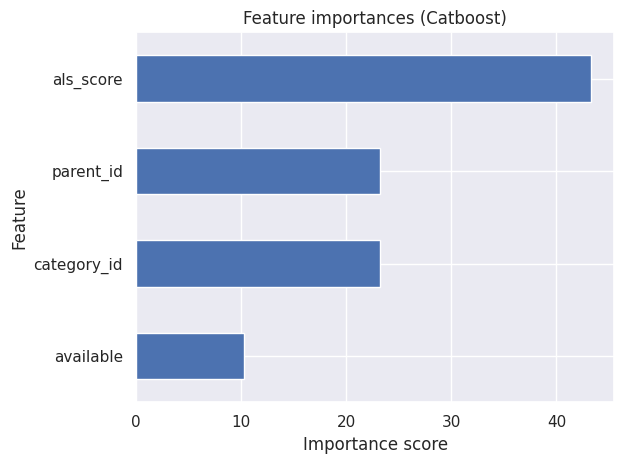

In [125]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_final_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances (Catboost)")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig(f"{ASSETS_DIR}/feature_importances.png")
plt.show()

Наиболее важным фактором модель считает сами скоры ALS-модели, что логично, ведь это по сути оцененные рейтинги для рекомендаций товаров. Далее, примерно в одинаковом соотношении находятся категориальные переменные для категорий товаров и наименее всего приходится на доступность товара.

### Computing metrics

Ранжированные рекомендации будут оцениваться исходя из `precision@10` и `recall@10` метрик. Сначала определим функции, которые будут отвечать за их расчет:

In [126]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):
    """Labels <user_id, item_id> pairs for common users with features:
    - gt => ground truth
    - pr => prediction
    top_k => using top-k recommendations for computation
    """
    
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(
        events_train["item_id"].unique()
    )
    ]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], 
        how="outer",
    )

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common


In [127]:
def compute_cls_metrics(events_recs_for_binary_metric):
    """Computes precision and recall."""
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # Computing precision
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # Computing recall
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

Считаем метрики:

In [128]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    candidates_inference_ranked.rename(columns={"cb_score": "score"}),
    top_k=10,
)

precision_at_10_personal, recall_at_10_personal = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@10 = {precision_at_10_personal:.5f} ({precision_at_10_personal:.3%})")
print(f"Recall@10 = {recall_at_10_personal:.5f} ({recall_at_10_personal:.3%})")

Precision@10 = 0.06524 (6.524%)
Recall@10 = 0.07024 (7.024%)


In [129]:
recommendation_metrics = {
    "precision_at_10": precision_at_10_personal,
    "recall_at_10": recall_at_10_personal
}
recommendation_metrics

{'precision_at_10': 0.06523967835443245, 'recall_at_10': 0.07024405949186102}

Получились не самые хорошие результаты, что может быть причиной наличия сильного дисбаланса классов в тренировочной выборке. Другими словами, среди топ-10 только 6.5% товаров было признано релевантными, а среди топ-10 только 7% товаров было индентифицировано.

Сохраним данный ранкинг, а также модель, которая была использована для их получения:

In [130]:
candidates_inference_ranked.to_parquet(f"{ASSETS_DIR}/personal_recommendations.parquet")

In [131]:
model.save_model(f"{POSTGRES_DATA_DIR}/catboost_model.cbm")

Заметим, что отранжированные рекомендации не сохраняем в директории Airflow, поскольку такие же рекомендации будут получены в ходе выполнения одного из графов, о чем будет подробнее рассказано в секции Airflow.

### Logging artifacts (Mlflow)

In [132]:
RUN_NAME = "recommendations_ranking"
REGISTERED_MODEL_NAME = "cb_ranking_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    mlflow.log_params(catboost_params)
    mlflow.log_metrics(recommendation_metrics)

    mlflow.log_artifact(f"{ASSETS_DIR}/personal_recommendations.parquet", "recommendations")
    mlflow.log_artifact(f"{ASSETS_DIR}/feature_importances.png", "cb_model")

    model_info = mlflow.catboost.log_model( 
            registered_model_name=REGISTERED_MODEL_NAME,
            cb_model=model,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements="../requirements.txt",
    )

/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/_distutils_hack/__init__.py:16: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'cb_ranking_model' already exists.

## Simple Catboost parameters tuning

Результаты, полученные на предыдущем этапе не вдохновляют, поэтом может попробовать немного потюнить параметры катбуста. Ввиду сложности и специфичности расчета метрик качества, не представляется возможно использования каких-то автоматизированных средств поиска и оптимизации гиперпараметров. Поэтому возьмем две комбинации параметров и посмотрим на метрики.

### Test 1

In [133]:
catboost_params = {
    "iterations": 1700,
    "learning_rate": 0.1,
    "depth": 5,
    "verbose": 200,
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}

In [134]:
# Pooling training data
train_data = Pool(
    data=candidates_train[features],
    label=candidates_train[target],
    cat_features=cat_features
)

model = CatBoostClassifier(**catboost_params)

# Launching training
model.fit(train_data)

0:	learn: 0.6529755	total: 3.13ms	remaining: 5.32s
200:	learn: 0.1171000	total: 454ms	remaining: 3.38s
400:	learn: 0.0539480	total: 956ms	remaining: 3.1s
600:	learn: 0.0334988	total: 1.46s	remaining: 2.67s
800:	learn: 0.0257362	total: 1.95s	remaining: 2.19s
1000:	learn: 0.0241743	total: 2.38s	remaining: 1.66s
1200:	learn: 0.0228792	total: 2.8s	remaining: 1.16s
1400:	learn: 0.0205593	total: 3.24s	remaining: 692ms
1600:	learn: 0.0193689	total: 3.67s	remaining: 227ms
1699:	learn: 0.0181817	total: 3.88s	remaining: 0us


In [135]:
# Predicting interaction probabilities
inf_data = Pool(data=candidates_inference[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_inference["cb_score"] = predictions[:, 1]

# Sorting the DataFrame to create rankings
candidates_inference_ranked = candidates_inference.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

# Ranking recommendations
candidates_inference_ranked["rank"] = candidates_inference_ranked.groupby("user_id").cumcount() + 1

candidates_inference_ranked["id"] = np.arange(1, candidates_inference_ranked.shape[0] + 1)
candidates_inference_ranked = candidates_inference_ranked.reset_index(drop=True)
candidates_inference_ranked

,id,rec_id,user_id,item_id,als_score,category_id,parent_id,available,cb_score,rank
0,1,1551,54791,417927,2.242130e-12,959,1095,0,0.243722,1
1,2,1554,54791,116624,2.194877e-12,959,1095,0,0.243722,2
2,3,1584,54791,393028,1.611422e-12,5,1637,0,0.075361,3
3,4,1553,54791,42002,2.203550e-12,1415,14,0,0.064321,4
4,5,1536,54791,92361,2.624674e-12,959,1095,1,0.039543,5
...,...,...,...,...,...,...,...,...,...,...
6094,6095,33538,1403769,412898,6.312227e-03,491,679,0,0.000029,96
6095,6096,33535,1403769,301721,6.762858e-03,470,520,1,0.000028,97
6096,6097,33503,1403769,11670,3.777569e-02,1135,1329,0,0.000014,98
6097,6098,33512,1403769,321905,1.550334e-02,1051,955,0,0.000011,99


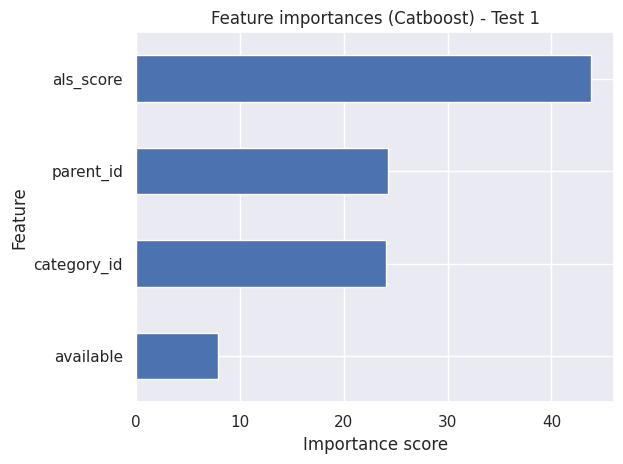

In [136]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_final_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances (Catboost) - Test 1")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig(f"{ASSETS_DIR}/feature_importances_2.png")
plt.show()

In [137]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    candidates_inference_ranked.rename(columns={"cb_score": "score"}),
    top_k=10,
)

precision_at_10_personal, recall_at_10_personal = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@10 = {precision_at_10_personal:.5f} ({precision_at_10_personal:.3%})")
print(f"Recall@10 = {recall_at_10_personal:.5f} ({recall_at_10_personal:.3%})")

Precision@10 = 0.05623 (5.623%)
Recall@10 = 0.08716 (8.716%)


In [138]:
recommendation_metrics = {
    "precision_at_10": precision_at_10_personal,
    "recall_at_10": recall_at_10_personal
}
recommendation_metrics

{'precision_at_10': 0.05623256524895869, 'recall_at_10': 0.08716407104555893}

In [139]:
candidates_inference_ranked.to_parquet(f"{ASSETS_DIR}/personal_recommendations_2.parquet")

In [140]:
RUN_NAME = "recommendations_ranking_t1"
REGISTERED_MODEL_NAME = "cb_ranking_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    mlflow.log_params(catboost_params)
    mlflow.log_metrics(recommendation_metrics)

    mlflow.log_artifact(f"{ASSETS_DIR}/personal_recommendations_2.parquet", "recommendations")
    mlflow.log_artifact(f"{ASSETS_DIR}/feature_importances_2.png", "cb_model")

    model_info = mlflow.catboost.log_model( 
            registered_model_name=REGISTERED_MODEL_NAME,
            cb_model=model,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements="../requirements.txt",
    )

/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/_distutils_hack/__init__.py:16: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'cb_ranking_model' already exists.

### Test 2

In [141]:
catboost_params = {
    "iterations": 3000,
    "verbose": 500,
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}

In [142]:
# Pooling training data
train_data = Pool(
    data=candidates_train[features],
    label=candidates_train[target],
    cat_features=cat_features
)

model = CatBoostClassifier(**catboost_params)

# Launching training
model.fit(train_data)

Learning rate set to 0.005981
0:	learn: 0.6895978	total: 3.23ms	remaining: 9.7s
500:	learn: 0.4393918	total: 1.17s	remaining: 5.84s
1000:	learn: 0.3689681	total: 2.25s	remaining: 4.5s
1500:	learn: 0.2885911	total: 3.39s	remaining: 3.38s
2000:	learn: 0.1810796	total: 4.7s	remaining: 2.35s
2500:	learn: 0.1311618	total: 6.01s	remaining: 1.2s
2999:	learn: 0.1039103	total: 7.34s	remaining: 0us


In [143]:
# Predicting interaction probabilities
inf_data = Pool(data=candidates_inference[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_inference["cb_score"] = predictions[:, 1]

# Sorting the DataFrame to create rankings
candidates_inference_ranked = candidates_inference.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

# Ranking recommendations
candidates_inference_ranked["rank"] = candidates_inference_ranked.groupby("user_id").cumcount() + 1

candidates_inference_ranked["id"] = np.arange(1, candidates_inference_ranked.shape[0] + 1)
candidates_inference_ranked = candidates_inference_ranked.reset_index(drop=True)
candidates_inference_ranked

,id,rec_id,user_id,item_id,als_score,category_id,parent_id,available,cb_score,rank
0,1,1554,54791,116624,2.194877e-12,959,1095,0,0.441740,1
1,2,1551,54791,417927,2.242130e-12,959,1095,0,0.435370,2
2,3,1508,54791,118914,5.266289e-12,1051,955,1,0.324898,3
3,4,1584,54791,393028,1.611422e-12,5,1637,0,0.296031,4
4,5,1536,54791,92361,2.624674e-12,959,1095,1,0.273581,5
...,...,...,...,...,...,...,...,...,...,...
6094,6095,33521,1403769,210087,1.074475e-02,1385,1202,0,0.009332,96
6095,6096,33512,1403769,321905,1.550334e-02,1051,955,0,0.008317,97
6096,6097,33503,1403769,11670,3.777569e-02,1135,1329,0,0.004268,98
6097,6098,33599,1403769,193828,2.139800e-03,819,798,0,0.002282,99


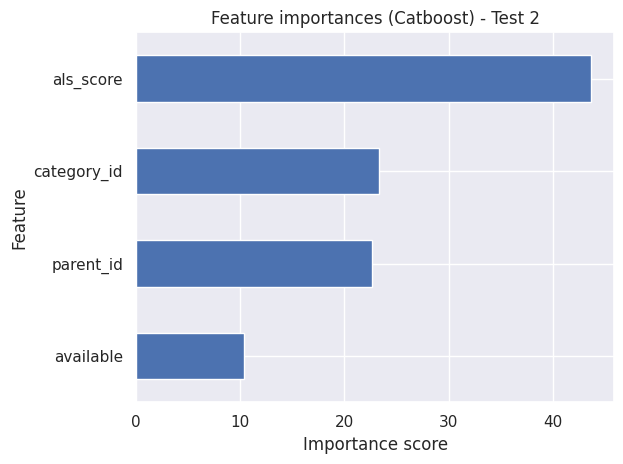

In [144]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_final_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances (Catboost) - Test 2")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig(f"{ASSETS_DIR}/feature_importances_3.png")
plt.show()

In [145]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    candidates_inference_ranked.rename(columns={"cb_score": "score"}),
    top_k=10,
)

precision_at_10_personal, recall_at_10_personal = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@10 = {precision_at_10_personal:.5f} ({precision_at_10_personal:.3%})")
print(f"Recall@10 = {recall_at_10_personal:.5f} ({recall_at_10_personal:.3%})")

Precision@10 = 0.06532 (6.532%)
Recall@10 = 0.07733 (7.733%)


In [146]:
recommendation_metrics = {
    "precision_at_10": precision_at_10_personal,
    "recall_at_10": recall_at_10_personal
}
recommendation_metrics

{'precision_at_10': 0.0653177423669227, 'recall_at_10': 0.077330959245234}

In [147]:
candidates_inference_ranked.to_parquet(f"{ASSETS_DIR}/personal_recommendations_3.parquet")

In [148]:
RUN_NAME = "recommendations_ranking_t2"
REGISTERED_MODEL_NAME = "cb_ranking_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    mlflow.log_params(catboost_params)
    mlflow.log_metrics(recommendation_metrics)

    mlflow.log_artifact(f"{ASSETS_DIR}/personal_recommendations_3.parquet", "recommendations")
    mlflow.log_artifact(f"{ASSETS_DIR}/feature_importances_3.png", "cb_model")

    model_info = mlflow.catboost.log_model( 
            registered_model_name=REGISTERED_MODEL_NAME,
            cb_model=model,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements="../requirements.txt",
    )

/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/_distutils_hack/__init__.py:16: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'cb_ranking_model' already exists.

### Choosing the best performing model

Если воспользоваться UI Mlflow, то можно наглядно посмотреть на сравнение полученных метрик, в ходе чего видим, что последняя модель с 3000 деревьев показала некоторое улучшение в `recall@10`. Выберем нее в качестве лучшей модели. 

Загрузим такую модель из Mlflow (она была у нас последней, поэтому у нас уже есть `model_uri`):

In [150]:
best_cb_model = mlflow.catboost.load_model(
    model_uri=model_info.model_uri
)

In [161]:
best_cb_model.get_params()

{'random_seed': 2049,
 'auto_class_weights': 'Balanced',
 'loss_function': 'Logloss',
 'iterations': 3000,
 'verbose': 500}

In [155]:
best_cb_model.is_fitted()

True

In [159]:
type(inf_data)

catboost.core.Pool

In [160]:
best_cb_model.predict(inf_data)

array([0, 0, 0, ..., 0, 0, 0])

Перезапишем модель, которую сохраняли во время первого прогона модели:

In [162]:
best_cb_model.save_model(f"{POSTGRES_DATA_DIR}/catboost_model.cbm")

## Conclusion